# 가설
* 조사구역 : 관악구, 금천구
* 공원면적이 클수록 공원보유시설(유희시설)이 많이 있을까?
* 어린이 공원 주변에 어린이 보호구역이 포함되어 있을까?

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import requests
import json
from collections import Counter
import seaborn as sns

import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)

In [2]:
# json파일을 읽어온다
def open_json(file_name, encoding):
    with open(file_name, encoding=encoding) as json_file: 
        json_object = json.load(json_file)
        json_string = json.dumps(json_object)
        json_data = json.loads(json_string)
    return json_data

In [3]:
json_data = open_json('전국도시공원정보표준데이터.json',encoding = 'utf-8')
#json_data

### => json 데이터를 불러온다

# 데이터 원본 분석

In [4]:
# 열과 데이터의 값을 가져온다
def get_df_info(json_data, records_root_name):
    column_list=[]
    all_data=[]
    is_first=True
    for record in json_data[records_root_name]:
        row_data_list=[]
        for key, value in record.items():
            if is_first:
                column_list.append(key)
            row_data_list.append(value)
        all_data.append(row_data_list)
        is_first=False
        
    return column_list, all_data

In [5]:
column_list, all_data = get_df_info(json_data,'records')

In [6]:
df = pd.DataFrame(all_data, columns=column_list)
df.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,제공기관코드,제공기관명
0,47190-00127,백현체육공원,체육공원,,경상북도 구미시 산동면 백현리 79,36.1864293331,128.4784906760,90967,,,,,,,,,2022-06-09,5080000,경상북도 구미시
1,47190-00128,둘모아공원,어린이공원,,경상북도 구미시 봉곡동 584-2,36.148431,128.3165938966,4279,,,,,,,,,2022-06-09,5080000,경상북도 구미시
2,47190-00129,다붓소공원,소공원,,경상북도 구미시 봉곡동 765 일원,36.155883,128.311526,805,,,,,,,,,2022-06-09,5080000,경상북도 구미시
3,47190-00130,다붓1공원,어린이공원,,경상북도 구미시 봉곡동 457-1,36.156392,128.314372,1585,,,,,,,,,2022-06-09,5080000,경상북도 구미시
4,47190-00131,다붓2공원,어린이공원,,경상북도 구미시 봉곡동 767,36.1548081316,128.314372,1637,,,,,,,,,2022-06-09,5080000,경상북도 구미시


### => json파일을 Df형식으로 만들어 주었다

In [7]:
df.shape

(16764, 19)

In [8]:
df= df[['공원명','공원구분','위도','경도','소재지지번주소','공원면적','공원보유시설(유희시설)']]
df.head()

,공원명,공원구분,위도,경도,소재지지번주소,공원면적,공원보유시설(유희시설)
0,백현체육공원,체육공원,36.1864293331,128.4784906760,경상북도 구미시 산동면 백현리 79,90967,
1,둘모아공원,어린이공원,36.148431,128.3165938966,경상북도 구미시 봉곡동 584-2,4279,
2,다붓소공원,소공원,36.155883,128.311526,경상북도 구미시 봉곡동 765 일원,805,
3,다붓1공원,어린이공원,36.156392,128.314372,경상북도 구미시 봉곡동 457-1,1585,
4,다붓2공원,어린이공원,36.1548081316,128.314372,경상북도 구미시 봉곡동 767,1637,


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16764 entries, 0 to 16763
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   공원명           16764 non-null  object
 1   공원구분          16764 non-null  object
 2   위도            16764 non-null  object
 3   경도            16764 non-null  object
 4   소재지지번주소       16764 non-null  object
 5   공원면적          16764 non-null  object
 6   공원보유시설(유희시설)  16764 non-null  object
dtypes: object(7)
memory usage: 916.9+ KB


### => df의 위도와 경도, 면적은 float 타입으로 변환해줘야 한다

In [10]:
df = df[(df['경도'] != "") & (df['위도'] != "") & (df['공원면적'] != "")]

In [11]:
df['위도'] = df['위도'].astype('float')
df['경도'] = df['경도'].astype('float')
df['공원면적'] = df['공원면적'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16606 entries, 0 to 16763
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   공원명           16606 non-null  object 
 1   공원구분          16606 non-null  object 
 2   위도            16606 non-null  float64
 3   경도            16606 non-null  float64
 4   소재지지번주소       16606 non-null  object 
 5   공원면적          16606 non-null  float64
 6   공원보유시설(유희시설)  16606 non-null  object 
dtypes: float64(3), object(4)
memory usage: 1.0+ MB


### => 원본데이터 분석 끝

## 결측치, 이상치 처리방안 결정

In [12]:
df.isnull().sum()

공원명             0
공원구분            0
위도              0
경도              0
소재지지번주소         0
공원면적            0
공원보유시설(유희시설)    0
dtype: int64

In [13]:
df[df['소재지지번주소'] == ''].shape

(334, 7)

#### => 주소가 둘다 결측지인 경우는 없다

In [14]:
df.drop(index = df[df['소재지지번주소']==''].index, inplace = True)

In [15]:
df[df['공원명']== '']

,공원명,공원구분,위도,경도,소재지지번주소,공원면적,공원보유시설(유희시설)


In [16]:
df[df['공원구분']== '']

,공원명,공원구분,위도,경도,소재지지번주소,공원면적,공원보유시설(유희시설)


In [17]:
len(df[df['공원보유시설(유희시설)']== ''])

10321

In [18]:
len(df[df['공원보유시설(유희시설)']== '-'])

29

In [19]:
len(df[df['공원면적']== ''])

0

In [20]:
df['공원보유시설(유희시설)'] = df['공원보유시설(유희시설)'].replace('','[시설미보유]')
df['공원보유시설(유희시설)'] = df['공원보유시설(유희시설)'].replace('-','[시설미보유]')
df['공원보유시설(유희시설)'] = df['공원보유시설(유희시설)'].replace('0','[시설미보유]')
df['공원보유시설(유희시설)'] = df['공원보유시설(유희시설)'].replace('1','[시설미보유]')
df.head()

,공원명,공원구분,위도,경도,소재지지번주소,공원면적,공원보유시설(유희시설)
0,백현체육공원,체육공원,36.186429,128.478491,경상북도 구미시 산동면 백현리 79,90967.0,[시설미보유]
1,둘모아공원,어린이공원,36.148431,128.316594,경상북도 구미시 봉곡동 584-2,4279.0,[시설미보유]
2,다붓소공원,소공원,36.155883,128.311526,경상북도 구미시 봉곡동 765 일원,805.0,[시설미보유]
3,다붓1공원,어린이공원,36.156392,128.314372,경상북도 구미시 봉곡동 457-1,1585.0,[시설미보유]
4,다붓2공원,어린이공원,36.154808,128.314372,경상북도 구미시 봉곡동 767,1637.0,[시설미보유]


### => 데이터 원본분석 끝

---

## Step 1. 전국의 어떤 공원이 가장 많이 존재하는가?

In [21]:
df['공원구분'].unique()

array(['체육공원', '어린이공원', '소공원', '근린공원', '수변공원', '문화공원', '묘지공원', '역사공원',
       '기타', '도시자연공원구역', '도시농업공원', '기타공원', '주제공원', '도시자연공원', '마을숲',
       '마을마당'], dtype=object)

In [22]:
df['공원구분'].value_counts()

어린이공원       8689
근린공원        3679
소공원         2494
문화공원         349
수변공원         301
기타           232
체육공원         228
역사공원         171
마을마당          49
묘지공원          35
기타공원          30
도시농업공원         7
도시자연공원         3
도시자연공원구역       2
주제공원           2
마을숲            1
Name: 공원구분, dtype: int64

In [23]:
df['공원구분'].replace('기타공원','기타공원', inplace=True)
df['공원구분'].replace('마을마당','기타공원', inplace=True)
df['공원구분'].replace('묘지공원','기타공원', inplace=True)
df['공원구분'].replace('도시농업공원','기타공원', inplace=True)
df['공원구분'].replace('도시자연공원','기타공원', inplace=True)
df['공원구분'].replace('도시자연공원구역','기타공원', inplace=True)
df['공원구분'].replace('주제공원','기타공원', inplace=True)
df['공원구분'].replace('마을숲','기타공원', inplace=True)
df['공원구분'].replace('기타','기타공원', inplace=True)

df['공원구분'].value_counts()

어린이공원    8689
근린공원     3679
소공원      2494
기타공원      361
문화공원      349
수변공원      301
체육공원      228
역사공원      171
Name: 공원구분, dtype: int64

In [24]:
df['공원구분'].unique()

array(['체육공원', '어린이공원', '소공원', '근린공원', '수변공원', '문화공원', '기타공원', '역사공원'],
      dtype=object)

### => 공원분류 중 100건이 안되는 데이터는 기타로 묶어서 분류 해 주었다

In [25]:
df2 = df.sort_values(by=['공원구분'])

<AxesSubplot:xlabel='count', ylabel='공원구분'>

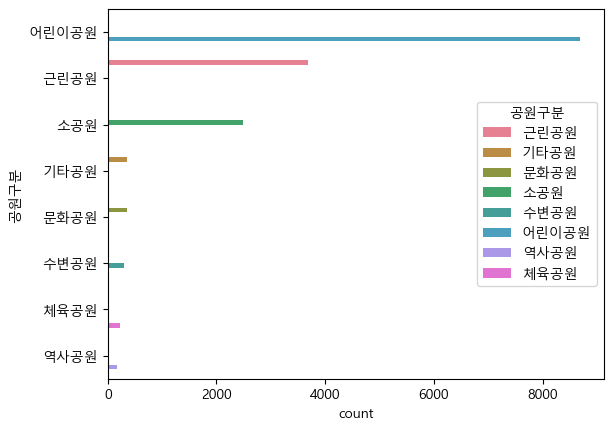

In [26]:
palette1 = sns.color_palette('husl',8)
sns.countplot(y=df2['공원구분'], order = df2['공원구분'].value_counts().index, hue="공원구분", data=df2, palette=palette1)

In [27]:
park_list=df.groupby('공원구분')['공원구분'].count().tolist()
park_list

[3679, 361, 349, 2494, 301, 8689, 171, 228]

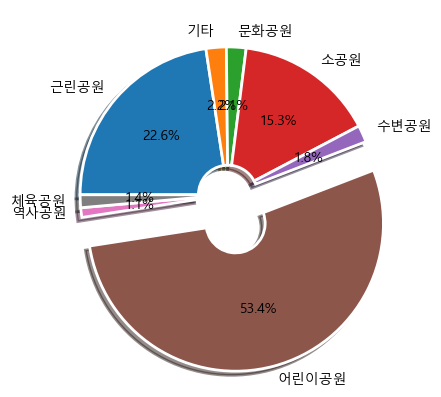

In [28]:
labels = ['근린공원','기타','문화공원','소공원','수변공원','어린이공원','역사공원','체육공원']
explode = [0, 0,0, 0, 0, 0.2, 0, 0]
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(park_list, labels=labels, autopct='%.1f%%', startangle=180, counterclock=False, shadow = True, wedgeprops=wedgeprops,explode=explode)

plt.show()

### => 전국의 공원을 구분하여 파이차트로 시각화 해주었다

# Step2 서울시 어린이공원의 분포도 확인

In [29]:
seoul_map = folium.Map(location=[37.541, 126.986],
               zoom_start=11, 
               width=750, 
               height=650
              )

In [30]:
seoul_map2 = folium.Map(location=[37.541, 126.986],
               zoom_start=11, 
               width=750, 
               height=650
              )

In [31]:
requests = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
content = requests.content
seoul_geo = json.loads(content)

In [32]:
folium.GeoJson(seoul_geo).add_to(seoul_map)
seoul_map

In [33]:
folium.GeoJson(seoul_geo).add_to(seoul_map2)

#### => 지도 기본셋팅

In [34]:
childpark = df[df['공원구분'] == '어린이공원']
childpark=childpark[childpark['소재지지번주소'].str.contains('서울')]
childpark

,공원명,공원구분,위도,경도,소재지지번주소,공원면적,공원보유시설(유희시설)
214,목련어린이공원,어린이공원,37.587380,126.880225,서울특별시 마포구 상암동1742,1501.0,[시설미보유]
215,산수유어린이공원,어린이공원,37.585485,126.879008,서울특별시 마포구 상암동1744,2011.0,[시설미보유]
216,산딸나무어린이공원,어린이공원,37.583547,126.877927,서울특별시 마포구 상암동1753,1499.0,[시설미보유]
217,애오개도담어린이공원,어린이공원,37.553433,126.958529,서울특별시 마포구 아현동 800-6,3212.0,[시설미보유]
218,쌍룡산어린이공원,어린이공원,37.552173,126.950512,서울특별시 마포구 아현동 769,5911.0,[시설미보유]
...,...,...,...,...,...,...,...
15266,한 신,어린이공원,37.588130,127.076900,서울특별시 중랑구 면목3·8 30-38,995.0,[시설미보유]
15267,이 화,어린이공원,37.586990,127.100300,서울특별시 중랑구 상봉2 114-1,215.0,[시설미보유]
15268,면목1(가칭),어린이공원,37.580278,127.093056,서울특별시 중랑구 상봉2 122-31,1578.6,[시설미보유]
15269,봉 황,어린이공원,37.595020,127.084800,서울특별시 중랑구 상봉2 136-35,1014.0,[시설미보유]


In [35]:
childpark_addr=childpark['소재지지번주소'].tolist()
childpark_addr

['서울특별시 마포구 상암동1742',
 '서울특별시 마포구 상암동1744',
 '서울특별시 마포구 상암동1753',
 '서울특별시 마포구 아현동 800-6',
 '서울특별시 마포구 아현동 769',
 '서울특별시 마포구 용강동 63-2',
 '서울특별시 마포구 아현동 802번지 일대',
 '서울특별시 마포구 망원동 458-64',
 '서울특별시 마포구 창전동 26-1',
 '서울특별시 마포구 신수동 95-5일원',
 '서울특별시 마포구 서교동 479-1',
 '서울특별시 마포구 동교동 168-1',
 '서울특별시 마포구 동교동 197-17',
 '서울특별시 마포구 서교동 489',
 '서울특별시 마포구 합정동 394-1',
 '서울특별시 마포구 망원동 381-1',
 '서울특별시 마포구 망원동 408-3',
 '서울특별시 마포구 망원2동 436-1',
 '서울특별시 마포구 망원2동 509-1',
 '서울특별시 마포구 연남동 563-5',
 '서울특별시 마포구 연남동 250-1',
 '서울특별시 마포구 성산동 113-2',
 '서울특별시 마포구 성산동 588-8',
 '서울특별시 마포구 성산동 587-18 일대',
 '서울특별시 마포구 성산동 667-1',
 '서울특별시 마포구 성산동 147-5',
 '서울특별시 마포구 성산동 200-50',
 '서울특별시 마포구 성산동 200-335',
 '서울특별시 마포구 성산동 199-11',
 '서울특별시 마포구 중동 36-27',
 '서울특별시 마포구 중동 228',
 '서울특별시 마포구 중동 36-34',
 '서울특별시 마포구 중동 40-5 일대',
 '서울특별시 마포구 상암동 1619',
 '서울특별시 마포구 상암동 14-5',
 '서울특별시 마포구 상암동 1636',
 '서울특별시 마포구 상암동 1656',
 '서울특별시 마포구 상암동 1681',
 '서울특별시 동작구 상도동 36-1',
 '서울특별시 동작구 상도1동 558',
 '서울특별시 마포구 공덕동 470-1',
 '서울특별시 마포구 공덕동 467-1,2

In [36]:
addr_list_childpark = []
for addr in childpark_addr: 
    addr_list_childpark.append(addr.split()[1])
addr_list_childpark

['마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '동작구',
 '동작구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '마포구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '강동구',
 '동작구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '양천구',
 '양천구',
 '양천구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '강북구',
 '양천구',
 '양천구',
 '강동구',
 '강동구',
 '강동구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '광진구',
 '양천구',


In [37]:
childpark['행정구별'] = addr_list_childpark
childpark = childpark[['공원명','공원구분','행정구별','위도','경도','공원면적','공원보유시설(유희시설)']]
childpark

,공원명,공원구분,행정구별,위도,경도,공원면적,공원보유시설(유희시설)
214,목련어린이공원,어린이공원,마포구,37.587380,126.880225,1501.0,[시설미보유]
215,산수유어린이공원,어린이공원,마포구,37.585485,126.879008,2011.0,[시설미보유]
216,산딸나무어린이공원,어린이공원,마포구,37.583547,126.877927,1499.0,[시설미보유]
217,애오개도담어린이공원,어린이공원,마포구,37.553433,126.958529,3212.0,[시설미보유]
218,쌍룡산어린이공원,어린이공원,마포구,37.552173,126.950512,5911.0,[시설미보유]
...,...,...,...,...,...,...,...
15266,한 신,어린이공원,중랑구,37.588130,127.076900,995.0,[시설미보유]
15267,이 화,어린이공원,중랑구,37.586990,127.100300,215.0,[시설미보유]
15268,면목1(가칭),어린이공원,중랑구,37.580278,127.093056,1578.6,[시설미보유]
15269,봉 황,어린이공원,중랑구,37.595020,127.084800,1014.0,[시설미보유]


In [38]:
marker_cluster_seoul_map = MarkerCluster().add_to(seoul_map)

In [39]:
for lat, lng in zip(childpark['위도'],childpark['경도']):

    Marker(location =[lat,lng],
          icon = folium.Icon(color="green")).add_to(marker_cluster_seoul_map)

In [40]:
seoul_map

In [41]:
childpark['count']=1
HeatMap(childpark[['위도','경도','count']]).add_to(seoul_map2)

seoul_map2

## Step3. 어린이보호구역 근처에는 어린이 구역이 있을것이다

In [42]:
children_json = open_json('전국어린이보호구역표준데이터.json',encoding = 'utf-8')
children_json

{'fields': [{'id': '시설종류'},
  {'id': '대상시설명'},
  {'id': '소재지도로명주소'},
  {'id': '소재지지번주소'},
  {'id': '위도'},
  {'id': '경도'},
  {'id': '관리기관명'},
  {'id': '관할경찰서명'},
  {'id': 'CCTV설치여부'},
  {'id': 'CCTV설치대수'},
  {'id': '보호구역도로폭'},
  {'id': '데이터기준일자'},
  {'id': '제공기관코드'},
  {'id': '제공기관명'}],
 'records': [{'시설종류': '초등학교',
   '대상시설명': '동해중앙초등교',
   '소재지도로명주소': '강원도 동해시 천곡로 35 (천곡동)',
   '소재지지번주소': '강원도 동해시 천곡동 793',
   '위도': '37.52533371',
   '경도': '129.1084972',
   '관리기관명': '강원도 동해시',
   '관할경찰서명': '동해경찰서',
   'CCTV설치여부': 'Y',
   'CCTV설치대수': '6',
   '보호구역도로폭': '11~30',
   '데이터기준일자': '2022-04-06',
   '제공기관코드': '4210000',
   '제공기관명': '강원도 동해시'},
  {'시설종류': '초등학교',
   '대상시설명': '천곡초등학교',
   '소재지도로명주소': '강원도 동해시 동굴로 33 (천곡동)',
   '소재지지번주소': '강원도 동해시 천곡동 320',
   '위도': '37.5177521',
   '경도': '129.1078672',
   '관리기관명': '강원도 동해시',
   '관할경찰서명': '동해경찰서',
   'CCTV설치여부': 'Y',
   'CCTV설치대수': '4',
   '보호구역도로폭': '20',
   '데이터기준일자': '2022-04-06',
   '제공기관코드': '4210000',
   '제공기관명': '강원도 동해시'},
  {'시설종류': '초등학

In [43]:
column_list, all_data = get_df_info(children_json,'records')

In [44]:
df_children = pd.DataFrame(all_data, columns = column_list)

df_children.head()

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,제공기관코드,제공기관명
0,초등학교,동해중앙초등교,강원도 동해시 천곡로 35 (천곡동),강원도 동해시 천곡동 793,37.52533371,129.1084972,강원도 동해시,동해경찰서,Y,6,11~30,2022-04-06,4210000,강원도 동해시
1,초등학교,천곡초등학교,강원도 동해시 동굴로 33 (천곡동),강원도 동해시 천곡동 320,37.5177521,129.1078672,강원도 동해시,동해경찰서,Y,4,20,2022-04-06,4210000,강원도 동해시
2,초등학교,망상초등학교,강원도 동해시 동해대로 6251 (망상동),강원도 동해시 망상동 360-2,37.59086742,129.0902466,강원도 동해시,동해경찰서,Y,3,21,2022-04-06,4210000,강원도 동해시
3,초등학교,동호초등학교,강원도 동해시 발한로 123 (발한동),강원도 동해시 발한동 570-1,37.54417872,129.1001844,강원도 동해시,동해경찰서,Y,6,20~28,2022-04-06,4210000,강원도 동해시
4,초등학교,동해초등학교,강원도 동해시 봉오주택길 22(용정동),강원도 동해시 용정동 475-3,37.51222384,129.1197999742,강원도 동해시,동해경찰서,Y,3,7~17,2022-04-06,4210000,강원도 동해시


In [45]:
df_children = df_children[(df_children['소재지지번주소'].str.contains('서울')) & df_children['소재지도로명주소'].str.contains('서울')]
df_children.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238 entries, 28 to 13596
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   시설종류      1238 non-null   object
 1   대상시설명     1238 non-null   object
 2   소재지도로명주소  1238 non-null   object
 3   소재지지번주소   1238 non-null   object
 4   위도        1238 non-null   object
 5   경도        1238 non-null   object
 6   관리기관명     1238 non-null   object
 7   관할경찰서명    1238 non-null   object
 8   CCTV설치여부  1238 non-null   object
 9   CCTV설치대수  1238 non-null   object
 10  보호구역도로폭   1238 non-null   object
 11  데이터기준일자   1238 non-null   object
 12  제공기관코드    1238 non-null   object
 13  제공기관명     1238 non-null   object
dtypes: object(14)
memory usage: 145.1+ KB


In [46]:
df_children['위도'] = df_children['위도'].astype(float)
df_children['경도'] = df_children['경도'].astype(float)

df_children.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238 entries, 28 to 13596
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      1238 non-null   object 
 1   대상시설명     1238 non-null   object 
 2   소재지도로명주소  1238 non-null   object 
 3   소재지지번주소   1238 non-null   object 
 4   위도        1238 non-null   float64
 5   경도        1238 non-null   float64
 6   관리기관명     1238 non-null   object 
 7   관할경찰서명    1238 non-null   object 
 8   CCTV설치여부  1238 non-null   object 
 9   CCTV설치대수  1238 non-null   object 
 10  보호구역도로폭   1238 non-null   object 
 11  데이터기준일자   1238 non-null   object 
 12  제공기관코드    1238 non-null   object 
 13  제공기관명     1238 non-null   object 
dtypes: float64(2), object(12)
memory usage: 145.1+ KB


In [47]:
df_children.isnull().sum()

시설종류        0
대상시설명       0
소재지도로명주소    0
소재지지번주소     0
위도          0
경도          0
관리기관명       0
관할경찰서명      0
CCTV설치여부    0
CCTV설치대수    0
보호구역도로폭     0
데이터기준일자     0
제공기관코드      0
제공기관명       0
dtype: int64

In [48]:
df_children[df_children['경도'] == ""]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,제공기관코드,제공기관명


In [49]:
df_children[df_children['위도'] == ""]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,제공기관코드,제공기관명


In [50]:
df_children[df_children['소재지도로명주소'] == ""]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,제공기관코드,제공기관명


In [51]:
df_children[df_children['소재지지번주소'] == ""]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,제공기관코드,제공기관명


In [52]:
df_children[df_children['CCTV설치여부'] == ""]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,제공기관코드,제공기관명


In [53]:
df_children = df_children[['시설종류','대상시설명','소재지지번주소','위도','경도','CCTV설치여부']]
df_children

,시설종류,대상시설명,소재지지번주소,위도,경도,CCTV설치여부
28,어린이집,나래어린이집,서울특별시 중랑구 면목2동 133-3,37.591727,127.083712,Y
29,어린이집,이화어린이집,서울특별시 중랑구 면목4동 715-1,37.573952,127.080811,Y
30,어린이집,상봉어린이집,서울특별시 중랑구 상봉1동 287-1,37.602026,127.090151,Y
31,어린이집,삼성어린이집,서울특별시 중랑구 상봉2동 107-1,37.594150,127.086921,Y
32,어린이집,한내들어린이집,서울특별시 중랑구 중화2동 332-48,37.604148,127.074977,Y
...,...,...,...,...,...,...
13590,특수학교,한국육영학교,서울특별시 송파구 장지동 45,37.482048,127.132505,Y
13591,초등학교,위례별초등학교,서울특별시 송파구 위례동 886,37.479086,127.145040,Y
13592,초등학교,잠신초등학교,서울특별시 송파구 잠실2동 22-10,37.514133,127.087919,Y
13593,유치원,티움유치원,서울특별시 송파구 송파2동 180-18,37.501103,127.115237,Y


In [54]:
df_children_addr = df_children['소재지지번주소'].tolist()
df_children_addr

['서울특별시 중랑구 면목2동 133-3',
 '서울특별시 중랑구 면목4동 715-1',
 '서울특별시 중랑구 상봉1동 287-1',
 '서울특별시 중랑구 상봉2동 107-1',
 '서울특별시 중랑구 중화2동 332-48',
 '서울특별시 중랑구 상봉1동 63',
 '서울특별시 중랑구 면목본동 547-4',
 '서울특별시 중랑구 중화1동 282-12',
 '서울특별시 중랑구 면목4동 380',
 '서울특별시 중랑구 망우본동 216',
 '서울특별시 중랑구 중화2동 316-30',
 '서울특별시 중랑구 묵1동 162-1',
 '서울특별시 중랑구 묵1동 11',
 '서울특별시 중랑구 면목7동 665-2',
 '서울특별시 중랑구 면목2동 183-120',
 '서울특별시 중랑구 면목4동 1382',
 '서울특별시 중랑구 신내2동 783',
 '서울특별시 중랑구 망우동 342-60',
 '서울특별시 중랑구 신내1동 241',
 '서울특별시 중랑구 묵2동 242-55',
 '서울특별시 중랑구 중화1동 119',
 '서울특별시 중랑구 면목2동 180-5',
 '서울특별시 중랑구 신내2동 663',
 '서울특별시 중랑구 신내2동 655',
 '서울특별시 중랑구 묵2동 242-55',
 '서울특별시 중랑구 면목본동 221',
 '서울특별시 중랑구 망우본동 216',
 '서울특별시 중랑구 신내2동 651',
 '서울특별시 중랑구 묵2동 246-12',
 '서울특별시 중랑구 중화1동 277-1',
 '서울특별시 중랑구 망우3동 440',
 '서울특별시 중랑구 신내2동 531',
 '서울특별시 중랑구 면목2동 192-1',
 '서울특별시 중랑구 면목4동 380',
 '서울특별시 중랑구 신내1동 444',
 '서울특별시 중랑구 면목3.8동 491-1',
 '서울특별시 중랑구 망우3동 119',
 '서울특별시 중랑구 면목본동 551',
 '서울특별시 중랑구 면목7동 583-15',
 '서울특별시 중랑구 망우본동 153-1',
 '서울특별시 중랑구 상봉1동 312-1',
 '서울특별시 

In [55]:
addr_list = []
for addr in df_children_addr: 
    addr_list.append(addr.split()[1])

In [56]:
df_children['행정구별'] = addr_list

df_children.head()

,시설종류,대상시설명,소재지지번주소,위도,경도,CCTV설치여부,행정구별
28,어린이집,나래어린이집,서울특별시 중랑구 면목2동 133-3,37.591727,127.083712,Y,중랑구
29,어린이집,이화어린이집,서울특별시 중랑구 면목4동 715-1,37.573952,127.080811,Y,중랑구
30,어린이집,상봉어린이집,서울특별시 중랑구 상봉1동 287-1,37.602026,127.090151,Y,중랑구
31,어린이집,삼성어린이집,서울특별시 중랑구 상봉2동 107-1,37.594150,127.086921,Y,중랑구
32,어린이집,한내들어린이집,서울특별시 중랑구 중화2동 332-48,37.604148,127.074977,Y,중랑구


In [57]:
df_children = df_children[['시설종류','대상시설명','행정구별','위도','경도','CCTV설치여부']]

df_children.head()

,시설종류,대상시설명,행정구별,위도,경도,CCTV설치여부
28,어린이집,나래어린이집,중랑구,37.591727,127.083712,Y
29,어린이집,이화어린이집,중랑구,37.573952,127.080811,Y
30,어린이집,상봉어린이집,중랑구,37.602026,127.090151,Y
31,어린이집,삼성어린이집,중랑구,37.594150,127.086921,Y
32,어린이집,한내들어린이집,중랑구,37.604148,127.074977,Y


#### => 필요한 열 재정렬

In [58]:
gwanak_map = folium.Map(location=[37.47826562816726,126.95148164982307],
               zoom_start=15, 
               width=750, 
               height=650
              )
gwanak_map

In [59]:
geumcheon_map = folium.Map(location=[ 37.456649804679,126.89508519654187],
               zoom_start=15, 
               width=750, 
               height=650
              )
geumcheon_map

In [60]:
df_children_gwanak = df_children[(df_children['행정구별'] == '관악구')]
childpark_gwanak = childpark[(childpark['행정구별'] == '관악구')]

In [61]:
df_children_geumcheon = df_children[(df_children['행정구별'] == '금천구')]
childpark_geumcheon = childpark[(childpark['행정구별'] == '금천구')]

### => 관악구와 금천구의 데이터만 보기 위해 전처리 해주었다

In [62]:
for name, lat, lng, m_num  in zip(childpark_gwanak['공원명'],childpark_gwanak['위도'],childpark_gwanak['경도'],childpark_gwanak['공원보유시설(유희시설)']):

    Marker(location =[lat,lng],
           popup=m_num,
           tooltip=name,
           icon=folium.Icon(color='orange',icon='bookmark')
           ).add_to(gwanak_map)
    folium.CircleMarker([lat, lng],
      radius= 30,
      color='tomato').add_to(gwanak_map)

In [63]:
for name, lat, lng, m_num  in zip(df_children_gwanak['CCTV설치여부'],df_children_gwanak['위도'],df_children_gwanak['경도'],df_children_gwanak['대상시설명']):

    Marker(location =[lat,lng],
           popup=m_num,
           tooltip=name,
           icon=folium.Icon(color='green',icon='star')
           ).add_to(gwanak_map)
gwanak_map

In [64]:
for name, lat, lng, m_num  in zip(childpark_geumcheon['공원명'],childpark_geumcheon['위도'],childpark_geumcheon['경도'],childpark_geumcheon['공원보유시설(유희시설)']):

    Marker(location =[lat,lng],
           popup=m_num,
           tooltip=name,
           icon=folium.Icon(color='orange',icon='bookmark')
           ).add_to(geumcheon_map)
    folium.CircleMarker([lat, lng],
      radius= 30,
      color='tomato').add_to(geumcheon_map)

In [65]:
for name, lat, lng, m_num  in zip(df_children_geumcheon['CCTV설치여부'],df_children_geumcheon['위도'],df_children_geumcheon['경도'],df_children_geumcheon['대상시설명']):

    Marker(location =[lat,lng],
           popup=m_num,
           tooltip=name,
           icon=folium.Icon(color='green',icon='star')
           ).add_to(geumcheon_map)
geumcheon_map

### => 주황색은 공원을 나타내고 초록색은 어린이보호구역을 나타낸다
### => 금천구 관악구의 어린이공원 반경200m 안에 어린이구역이 포함되는 곳이 많지 않다.

In [66]:
park_area = childpark.sort_values(by=['공원면적'],ascending=False)
park_area

,공원명,공원구분,행정구별,위도,경도,공원면적,공원보유시설(유희시설),count
13655,실락어린이공원,어린이공원,서대문구,37.594473,126.943334,17452.0,[시설미보유],1
9448,천상,어린이공원,송파구,37.494277,127.159174,12464.0,[시설미보유],1
9205,삼선,어린이공원,성북구,37.583236,127.010390,10957.0,"그네2, 모래밭1, 시소1, 정글집1, 조합놀이대1",1
981,구의공원,어린이공원,광진구,37.536503,127.094741,10464.0,"조합놀이대, 그네, 시소, 흔들놀이기구",1
3549,남강,어린이공원,관악구,37.473461,126.924653,10350.0,그네+미끄럼틀+흔들말+조합놀이대,1
...,...,...,...,...,...,...,...,...
10162,별 빛,어린이공원,노원구,37.619274,127.072555,132.5,[시설미보유],1
264,샘터어린이공원,어린이공원,마포구,37.569894,126.906749,123.0,[시설미보유],1
10164,목 련,어린이공원,노원구,37.636208,127.074429,112.0,[시설미보유],1
9578,돌무데기,어린이공원,송파구,37.492001,127.155103,97.6,[시설미보유],1
